<a href="https://colab.research.google.com/github/saanvi0204/credit_card_fraud_detection/blob/main/classifying_using_ensemble_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import load_model, Model
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, matthews_corrcoef, make_scorer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

import time
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [ ]:
autoencoder = load_model('/content/drive/MyDrive/Autoencoders/Credit card fraud detection/best_ae_model1.keras')
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Autoencoders/Credit card fraud detection/processed_df.csv")

In [ ]:
feature_cols = df.columns.drop('Class')
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [ ]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V17,V18,V19,V20,V21,V24,V27,V28,Log_Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,0.244863,0.030770,0.496282,0.326118,-0.024923,0.110507,0.330892,-0.063781,1.124303,0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.135170,-0.218763,-0.179086,-0.089611,-0.307377,-0.561131,-0.022256,0.044608,-1.114639,0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,1.306868,-0.144790,-2.778561,0.680975,0.337632,-1.138092,-0.137137,-0.181021,1.682368,0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.805445,2.345305,-1.514205,-0.269855,-0.147443,-1.941027,0.155396,0.186189,1.009339,0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.279081,-0.045569,0.987037,0.529939,-0.012839,0.233250,0.543620,0.651816,0.670241,0


## Combining latent features and reconstruction error

In [ ]:
X = df.drop('Class', axis=1).values
y = df['Class'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE)

In [ ]:
train_pred = autoencoder.predict(X_train)
test_pred = autoencoder.predict(X_test)

6231/6231 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [ ]:
train_recon_error = np.mean(np.abs(X_train - train_pred), axis=1).reshape(-1, 1)
test_recon_error = np.mean(np.abs(X_test - test_pred), axis=1).reshape(-1, 1)

In [ ]:
enc_train = encoder_model.predict(X_train)
enc_test = encoder_model.predict(X_test)

6231/6231 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [ ]:
combined_train_features = np.hstack([enc_train, train_recon_error])
combined_test_features = np.hstack([enc_test, test_recon_error])

## Comparing models

In [ ]:
param_grids = {
    "random_forest": {
        "n_estimators": [50, 100],
        "max_depth": [10, 20],
        "min_samples_leaf": [1, 2]
    },
    "adaboost": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 1]
    },
    "gradient_boosting": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5]
    },
    "lightgbm": {
        "n_estimators": [50, 100],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 30]
    }
}

In [ ]:
models = {
    "random_forest": RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
    "adaboost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "gradient_boosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "lightgbm": LGBMClassifier(random_state=RANDOM_STATE, class_weight='balanced')
}

In [ ]:
best_models = {}
evaluation_results = {}
scorer = make_scorer(f1_score)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

for model_name, model in models.items():
    print(f"\nTuning {model_name}...")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=5,
        scoring=scorer,
        cv=cv,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    start_time = time.time()
    search.fit(combined_train_features, y_train)
    duration = time.time() - start_time

    best_model = search.best_estimator_
    best_models[model_name] = best_model

    print(f"Best parameters for {model_name}: {search.best_params_}")
    print(f"Training time: {duration:.2f} seconds")

    predictions = best_model.predict(combined_test_features)
    probas = best_model.predict_proba(combined_test_features)[:, 1]

    accuracy = accuracy_score(y_test, predictions)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_test, predictions)
    mcc = matthews_corrcoef(y_test, predictions)

    evaluation_results[model_name] = {
        "Accuracy": accuracy,
        "TPR": tpr,
        "TNR": tnr,
        "F1 Score": f1,
        "MCC": mcc
    }


Tuning random_forest...
Best parameters for random_forest: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 10}
Training time: 547.22 seconds

Tuning adaboost...
Best parameters for adaboost: {'n_estimators': 100, 'learning_rate': 1}
Training time: 473.27 seconds

Tuning gradient_boosting...
Best parameters for gradient_boosting: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
Training time: 1360.18 seconds

Tuning lightgbm...
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4335
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Best parameters for lightgbm: {'num_leaves': 20, 'n_est

In [ ]:
print("\n Model Performance Summary:")
for model_name, metrics in evaluation_results.items():
    print(f"\n🔹 {model_name.upper()} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


 Model Performance Summary:

🔹 RANDOM_FOREST Performance:
Accuracy: 0.9991
TPR: 0.7162
TNR: 0.9996
F1 Score: 0.7413
MCC: 0.7413

🔹 ADABOOST Performance:
Accuracy: 0.9988
TPR: 0.4324
TNR: 0.9998
F1 Score: 0.5517
MCC: 0.5735

🔹 GRADIENT_BOOSTING Performance:
Accuracy: 0.9989
TPR: 0.4459
TNR: 0.9998
F1 Score: 0.5739
MCC: 0.5986

🔹 LIGHTGBM Performance:
Accuracy: 0.9993
TPR: 0.7838
TNR: 0.9996
F1 Score: 0.7864
MCC: 0.7861


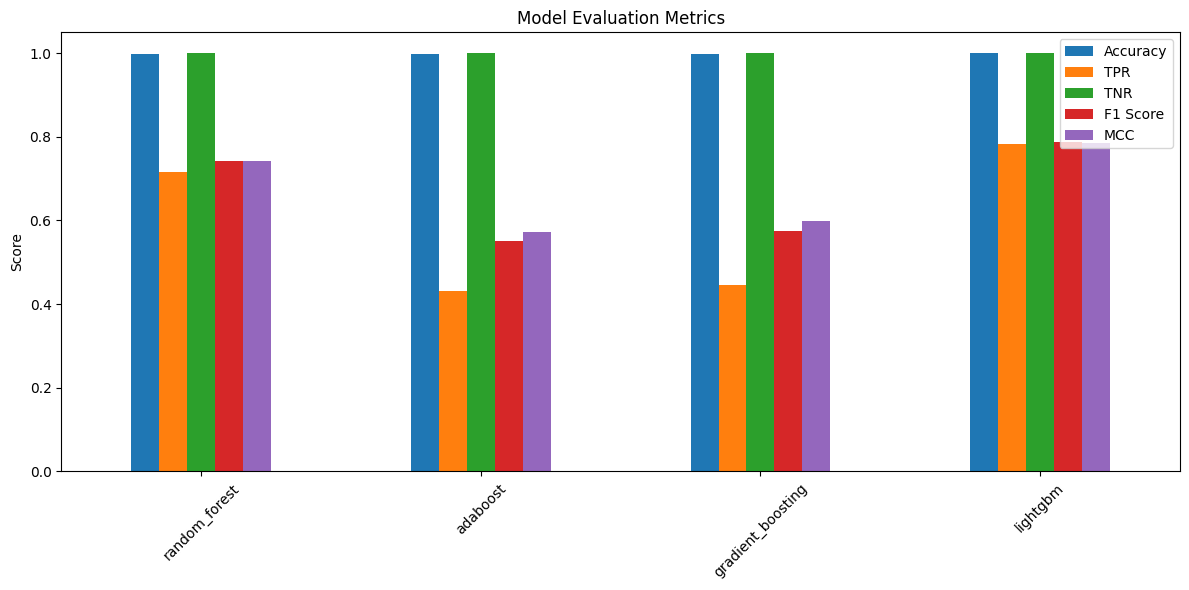

In [ ]:
metrics_df = pd.DataFrame(evaluation_results).T
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()